# Mongo DB + API

## MongoDB

https://motor.readthedocs.io/en/stable/tutorial-asyncio.html

> **Dopo video**
>
> [MongoDB with Python Crash Course - Tutorial for Beginners 2h](https://www.youtube.com/watch?v=E-1xI85Zog8)

In [1]:
!pip install motor

     |████████████████████████████████| 55 kB 433 kB/s            
     |████████████████████████████████| 516 kB 1.1 MB/s            


In [2]:
!pip install pymongo

In [3]:
import pandas as pd

def displayData(data):
    df = pd.DataFrame(data)
    display(df)

### Connection

In [4]:
user = 'root'
password = 'example'
host = 'mongo'
port = '27017'

In [6]:
connectionString = f'mongodb://{user}:{password}@{host}:{port}'

### Connection Async

In [7]:
#should be used inside of Tornado library
#import motor.motor_asyncio
#client = motor.motor_tornado.MotorClient(connectionString)

from motor.motor_asyncio import AsyncIOMotorClient
client = AsyncIOMotorClient(connectionString)

print(client)
dbs = list(await client.list_database_names())
print(dbs)

AsyncIOMotorClient(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=False, driver=DriverInfo(name='Motor', version='2.5.1', platform='asyncio')))
['admin', 'config', 'local']


In [10]:
db = client['test_database']

In [11]:
#result = await db.create_collection('test_collection')
#print(result)

## Random Data

In [8]:
import random 

def randomUser(mod='main'):
    surNames = [
        'Novák', 'Nováková', 'Svobodová', 'Svoboda', 'Novotná',
        'Novotný', 'Dvořáková', 'Dvořák', 'Černá', 'Černý', 
        'Procházková', 'Procházka', 'Kučerová', 'Kučera', 'Veselá',
        'Veselý', 'Horáková', 'Krejčí', 'Horák', 'Němcová', 
        'Marková', 'Němec', 'Pokorná', 'Pospíšilová','Marek'
    ]

    names = [
        'Jiří', 'Jan', 'Petr', 'Jana', 'Marie', 'Josef',
        'Pavel', 'Martin', 'Tomáš', 'Jaroslav', 'Eva',
        'Miroslav', 'Hana', 'Anna', 'Zdeněk', 'Václav',
        'Michal', 'František', 'Lenka', 'Kateřina',
        'Lucie', 'Jakub', 'Milan', 'Věra', 'Alena'
    ]

    name1 = random.choice(names)
    name2 = random.choice(names)
    name3 = random.choice(surNames)
    email = f'{name1}.{name2}.{name3}@{mod}.university.world'
    return {'name': f'{name1} {name2}', 'surname': name3, 'email': email}

def randomDepartment(mod='1', index=0, teachersCount=10):
    name = f"K{mod}{index+1}_{random.choice(['B', 'C', 'K'])}{random.choice(['A', 'E', 'I'])}"
    result = {
        'name': name,
        'teachers': [randomUser() for _ in range(teachersCount)]
    }
    return result
    

## CRUD Ops

https://motor.readthedocs.io/en/stable/tutorial-asyncio.html

Bez ohledu na typ databáze jsou operace CRUD vždy základním prvkem.

### Create

In [95]:
from bson.objectid import ObjectId

async def mongoCreateDoc(collection, doc):
    result = await collection.insert_one(doc)
    return result.inserted_id

async def mongoCreateDocAndReturn(collection, doc):
    result = await collection.insert_one(doc)
    result = await collection.find_one({'_id': {'$eq': ObjectId(result.inserted_id)}})
    return result

In [79]:
async def mongoCreateDocs(collection, *docs):
    result = await collection.insert_many(docs)
    return result.inserted_ids

async def mongoCreateDocsAndReturn(collection, *docs):
    result = await collection.insert_many(docs)
    results = [collection.find_one({'_id': {'$eq': ObjectId(inserted_id)}}) for inserted_id in result.inserted_ids]
    return await asyncio.gather(*results)

In [82]:
collection = client['test_database']['users']
newUser = await mongoCreateDocAndReturn(collection, randomUser())
print(newUser)

625682de4015779cfa898381
{'_id': ObjectId('625682de4015779cfa898381'), 'name': 'Martin Věra', 'surname': 'Pokorná', 'email': 'Martin.Věra.Pokorná@main.university.world'}


In [83]:
tenUsers = [randomUser() for _ in range(10)]
insertedUsers = await mongoCreateDocsAndReturn(collection, *tenUsers)
for index, user in enumerate(insertedUsers):
    print(index, user)

0 {'_id': ObjectId('625682df4015779cfa898382'), 'name': 'Marie Jakub', 'surname': 'Kučerová', 'email': 'Marie.Jakub.Kučerová@main.university.world'}
1 {'_id': ObjectId('625682df4015779cfa898383'), 'name': 'Kateřina Lenka', 'surname': 'Nováková', 'email': 'Kateřina.Lenka.Nováková@main.university.world'}
2 {'_id': ObjectId('625682df4015779cfa898384'), 'name': 'Václav Josef', 'surname': 'Marek', 'email': 'Václav.Josef.Marek@main.university.world'}
3 {'_id': ObjectId('625682df4015779cfa898385'), 'name': 'Jan Martin', 'surname': 'Svobodová', 'email': 'Jan.Martin.Svobodová@main.university.world'}
4 {'_id': ObjectId('625682df4015779cfa898386'), 'name': 'Lenka Lucie', 'surname': 'Horák', 'email': 'Lenka.Lucie.Horák@main.university.world'}
5 {'_id': ObjectId('625682df4015779cfa898387'), 'name': 'Jaroslav Alena', 'surname': 'Němcová', 'email': 'Jaroslav.Alena.Němcová@main.university.world'}
6 {'_id': ObjectId('625682df4015779cfa898388'), 'name': 'Josef Jana', 'surname': 'Marková', 'email': 'Jose

### Read Multi

In [84]:
async def mongoReadDocs(collection, query={}, skip=0, limit=100):
    cursor = collection.find(query).skip(skip).limit(limit)
    documents = await cursor.to_list(limit)
    return documents

In [85]:
collection = client['test_database']['users']
for index, doc in enumerate(await mongoReadDocs(collection)):
    print(index, doc)

0 {'_id': ObjectId('625673224015779cfa89834f'), 'name': 'Josef Jan', 'surname': 'Nowak', 'email': 'Josef.Jan.Němcová@main.university.world'}
1 {'_id': ObjectId('625673224015779cfa898350'), 'name': 'Tomáš Anna', 'surname': 'Veselá', 'email': 'Tomáš.Anna.Veselá@main.university.world'}
2 {'_id': ObjectId('625673224015779cfa898351'), 'name': 'Miroslav Lenka', 'surname': 'Pospíšilová', 'email': 'Miroslav.Lenka.Pospíšilová@main.university.world'}
3 {'_id': ObjectId('625673224015779cfa898352'), 'name': 'Eva Věra', 'surname': 'Veselá', 'email': 'Eva.Věra.Veselá@main.university.world'}
4 {'_id': ObjectId('625673224015779cfa898353'), 'name': 'Pavel Zdeněk', 'surname': 'Pospíšilová', 'email': 'Pavel.Zdeněk.Pospíšilová@main.university.world'}
5 {'_id': ObjectId('625673224015779cfa898354'), 'name': 'Jaroslav Marie', 'surname': 'Marek', 'email': 'Jaroslav.Marie.Marek@main.university.world'}
6 {'_id': ObjectId('625673224015779cfa898355'), 'name': 'Michal Václav', 'surname': 'Svoboda', 'email': 'Micha

### Read

In [24]:
async def mongoReadDoc(collection, doc):
    return await collection.find_one({'_id': doc['_id']})

In [27]:
collection = client['test_database']['users']
firstUser = (await mongoReadDocs(collection, limit=1))[0]
print(firstUser)
firstUserId = firstUser['_id']
user = await mongoReadDoc(collection, {'_id': firstUserId})
print(user)

{'_id': ObjectId('625673224015779cfa89834d'), 'name': 'Marie Kateřina', 'surname': 'Svobodová', 'email': 'Marie.Kateřina.Svobodová@main.university.world'}
{'_id': ObjectId('625673224015779cfa89834d'), 'name': 'Marie Kateřina', 'surname': 'Svobodová', 'email': 'Marie.Kateřina.Svobodová@main.university.world'}


### Update

Mongo podporuje dva typy změn:
- replacement
- klasický update

In [36]:
async def mongoReplaceDoc(collection, doc):
    replacementDoc = {**doc}
    del replacementDoc['_id']
    result = await collection.replace_one({'_id': doc['_id']}, replacementDoc)
    return result

In [37]:
async def mongoReplaceDocAndReturn(collection, doc):
    replacementDoc = {**doc}
    del replacementDoc['_id']
    result = await collection.replace_one({'_id': doc['_id']}, replacementDoc)
    return replacementDoc

In [45]:
async def mongoUpdateDoc(collection, doc):
    updatingDoc = {**doc}
    del updatingDoc['_id']
    result = await collection.update_one({'_id': doc['_id']}, {'$set': updatingDoc})
    return result

In [46]:
async def mongoUpdateDocAndReturn(collection, doc):
    updatingDoc = {**doc}
    del updatingDoc['_id']
    result = await collection.update_one({'_id': doc['_id']}, {'$set': updatingDoc})
    return await collection.find_one({'_id': doc['_id']})

In [47]:
collection = client['test_database']['users']
firstUser = (await mongoReadDocs(collection, limit=3))[2]
print(firstUser)
firstUserId = firstUser['_id']

collection = client['test_database']['users']
result = await mongoUpdateDocAndReturn(collection, {'_id': firstUserId, 'surname': 'Nowak'})
print(result)

{'_id': ObjectId('625673224015779cfa89834f'), 'name': 'Josef Jan', 'surname': 'Němcová', 'email': 'Josef.Jan.Němcová@main.university.world'}
{'_id': ObjectId('625673224015779cfa89834f'), 'name': 'Josef Jan', 'surname': 'Nowak', 'email': 'Josef.Jan.Němcová@main.university.world'}


### Delete

In [52]:
async def mongoDeleteDoc(collection, doc):
    result = await collection.delete_many(doc)
    return {'ok': True}

In [54]:
collection = client['test_database']['users']
firstUser = (await mongoReadDocs(collection, limit=1))[0]
print(firstUser)
firstUserId = firstUser['_id']

deleted = await mongoDeleteDoc(collection, firstUser)
nextUser = (await mongoReadDocs(collection, limit=1))[0]
print(nextUser)

{'_id': ObjectId('625673224015779cfa89834e'), 'surname': 'Nowak'}
{'_id': ObjectId('625673224015779cfa89834f'), 'name': 'Josef Jan', 'surname': 'Nowak', 'email': 'Josef.Jan.Němcová@main.university.world'}


## Relace?

Relace v databázi, která není relační zní tak trochu jako nesmysl. Faktem ale zůstává, že i v mongoDB uložené dokumenty (dokumentová databáze) musí být identifikovatelné, aby byly jednotlivé dokumenty dohledatelné. Znamená to, že v databázích, které uchovávají "vnější" odkazy musí být uložen identifikátor. Pokud je takový "vnější" identifikátor uložen v mongoDB a má být optimalizováno vyhledávání dokumentů podle tohoto identifikátoru, musí existovat index (obecný princip).

Příklad z relačních databází, kdy máme dokument o skupině (katedra) a dokumenty o uživatelech (učitelích - příslušnících katedry).

In [100]:
groupCollection = client['test_database']['groups']
department = randomDepartment()
print(department)

{'name': 'K11_BE', 'teachers': [{'name': 'František Jakub', 'surname': 'Kučerová', 'email': 'František.Jakub.Kučerová@main.university.world'}, {'name': 'Jaroslav Alena', 'surname': 'Marková', 'email': 'Jaroslav.Alena.Marková@main.university.world'}, {'name': 'Tomáš Michal', 'surname': 'Veselý', 'email': 'Tomáš.Michal.Veselý@main.university.world'}, {'name': 'Václav Alena', 'surname': 'Kučera', 'email': 'Václav.Alena.Kučera@main.university.world'}, {'name': 'Lucie Jana', 'surname': 'Dvořák', 'email': 'Lucie.Jana.Dvořák@main.university.world'}, {'name': 'Michal Anna', 'surname': 'Dvořáková', 'email': 'Michal.Anna.Dvořáková@main.university.world'}, {'name': 'Jakub Alena', 'surname': 'Marková', 'email': 'Jakub.Alena.Marková@main.university.world'}, {'name': 'Jaroslav Jiří', 'surname': 'Marek', 'email': 'Jaroslav.Jiří.Marek@main.university.world'}, {'name': 'Hana Věra', 'surname': 'Veselá', 'email': 'Hana.Věra.Veselá@main.university.world'}, {'name': 'Kateřina Hana', 'surname': 'Černá', 'em

Lze samozřejmě uložit kompletní dokument, ale jak budeme pracovat s jednotlivými uživateli?

In [101]:
departmentDoc = await mongoCreateDocAndReturn(groupCollection, {'name': department['name']})
print(departmentDoc)

{'_id': ObjectId('625689ec4015779cfa8983b9'), 'name': 'K11_BE'}


In [97]:
userCollection = client['test_database']['groups']
teachers = [{**teacher, 'groups': [{'_id': departmentDoc['_id']}]} for teacher in department['teachers']]
teachersDocs = await mongoCreateDocsAndReturn(userCollection, *teachers)
for index, teacher in enumerate(teachersDocs):
    print(index, teacher)   

0 {'_id': ObjectId('6256868b4015779cfa8983af'), 'name': 'Václav Lenka', 'surname': 'Nováková', 'email': 'Václav.Lenka.Nováková@main.university.world', 'groups': [{'_id': ObjectId('625686894015779cfa8983ae')}]}
1 {'_id': ObjectId('6256868b4015779cfa8983b0'), 'name': 'Hana Lenka', 'surname': 'Němec', 'email': 'Hana.Lenka.Němec@main.university.world', 'groups': [{'_id': ObjectId('625686894015779cfa8983ae')}]}
2 {'_id': ObjectId('6256868b4015779cfa8983b1'), 'name': 'Pavel Miroslav', 'surname': 'Dvořáková', 'email': 'Pavel.Miroslav.Dvořáková@main.university.world', 'groups': [{'_id': ObjectId('625686894015779cfa8983ae')}]}
3 {'_id': ObjectId('6256868b4015779cfa8983b2'), 'name': 'Věra Kateřina', 'surname': 'Černá', 'email': 'Věra.Kateřina.Černá@main.university.world', 'groups': [{'_id': ObjectId('625686894015779cfa8983ae')}]}
4 {'_id': ObjectId('6256868b4015779cfa8983b3'), 'name': 'Zdeněk Hana', 'surname': 'Procházka', 'email': 'Zdeněk.Hana.Procházka@main.university.world', 'groups': [{'_id'

In [98]:
teachersIds = [teacher['_id'] for teacher in teachersDocs]
newDepartmentDoc = await mongoUpdateDocAndReturn(groupCollection, {**departmentDoc, 'teachers': teachersIds})
print(newDepartmentDoc)

{'_id': ObjectId('625686894015779cfa8983ae'), 'name': 'K11_BE', 'teachers': [ObjectId('6256868b4015779cfa8983af'), ObjectId('6256868b4015779cfa8983b0'), ObjectId('6256868b4015779cfa8983b1'), ObjectId('6256868b4015779cfa8983b2'), ObjectId('6256868b4015779cfa8983b3'), ObjectId('6256868b4015779cfa8983b4'), ObjectId('6256868b4015779cfa8983b5'), ObjectId('6256868b4015779cfa8983b6'), ObjectId('6256868b4015779cfa8983b7'), ObjectId('6256868b4015779cfa8983b8')]}


Všimněte si duplicity dat, u uživatelů je seznam skupin, jichž jsou členem, obdobně u skupiny je seznam uživatelů. Jak provedem operaci změny seznamu uživatelů u skupiny?

## Local Tests

In [18]:
from bson.objectid import ObjectId
collection = client['test_database']['test_collection']

documents = await mongoReadDocs(collection, query={'name': 'user_QHXQNTPD'})
print(documents)

documents = await mongoReadDoc(collection, doc={'_id': ObjectId('606ec05c6b84c76e2a73545f')})
print(documents)

documents = await mongoReadDocs(collection)
displayData(documents)

documents = await mongoReadDocs(collection, skip=25, limit=2)
displayData(documents)

[{'_id': ObjectId('6080497757e0faf209cefc60'), 'name': 'user_QHXQNTPD', 'group': 'group_HWAXFSQG', 'phone': 649929595, 'age': 60, 'incomeY': 986565, 'actualDebt': 73058}]
{'_id': ObjectId('606ec05c6b84c76e2a73545f'), 'key': 'value'}


,_id,key,i,name,group,phone,age,incomeY,actualDebt,street,city,secondarySchool,primarySchool
0,606ec05c6b84c76e2a73545f,value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,606ec09a6b84c76e2a735460,value,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,606ec0a26b84c76e2a735461,value,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,606ecb166b84c76e2a735462,value,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,606ecb4f6b84c76e2a735463,value,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,606ecb4f6b84c76e2a735464,value,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,606ecb4f6b84c76e2a735465,value,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,606ecb4f6b84c76e2a735466,value,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,606ecb4f6b84c76e2a735467,value,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,606ecb4f6b84c76e2a735468,value,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,_id,name,group,phone,age,incomeY,actualDebt,street,city
0,6080497757e0faf209cefc60,user_QHXQNTPD,group_HWAXFSQG,649929595,60,986565,73058,NaN,NaN
1,6080497757e0faf209cefc61,user_ZGZREBJX,group_RQSQJVFP,755276379,39,937108,4960078,street_JLFGTQLT,city_AWKREGGU


## GraphQL API

### Resolvery

Jak vypadají root resolvery?

In [102]:
def root_resolve_user(parent, info, id):
    return None

def root_resolve_group(parent, info, id):
    return None

Jak vypadají ostatní resolvery?

In [103]:
def resolver_users_fromGroup(parent, info):
    return []

def resolve_groups_fromUser(parent, info):
    return []

### Datové typy

In [5]:
import graphene

class UserGQL(graphene.ObjectType):
    """Represents an user. User can be connected to several groups where the user is member. Also the user can play several roles."""
    id = graphene.ID()
    name = graphene.String()
    surname = graphene.String()
    email = graphene.String()
    
    groups = graphene.Field(graphene.List(lambda: GroupGQL))
    
    def resolve_groups(parent, info):
        return []
    
    roles = graphene.Field(graphene.List(lambda: RoleGQL))
    
    def resolve_roles(parent, info):
        return []
    
class GroupTypeGQL(graphene.ObjectType): 
    """"Represents a type of group such as "faculty" or "department". """
    id = graphene.ID()
    name = graphene.String()
    
    groups = graphene.List(lambda: GroupGQL)   
    
    def resolve_groups(parent, info):
        return []
    
class GroupGQL(graphene.ObjectType):
    """"Represents a group which has several members - users. Group is defined by its type, also it has a parent and children."""
    id = graphene.ID()
    name = graphene.String()
    users = graphene.List(UserGQL)
    
    def resolve_users(parent, info):
        return []

    parent = graphene.Field(lambda: GroupGQL)
    
    def resolve_parent(parent, info):
        return None
        
    children = graphene.Field(graphene.List(lambda: GroupGQL))
    
    def resolve_children(parent, info):
        return []
    
    grouptype = graphene.Field(lambda: GroupTypeGQL)
    
    def resolve_grouptype(parent, info):
        return None
    
class RoleTypeGQL(graphene.ObjectType):
    """Represents a role type such as "dean" or "chief" """
    id = graphene.ID()
    name = graphene.String()
    roles = graphene.List(lambda: RoleGQL)
    
    def resolve_roles(parent, info):
        return []
                      
    
class RoleGQL(graphene.ObjectType):
    """"An user could have a role in a group."""
    user = graphene.Field(UserGQL)
    group = graphene.Field(GroupGQL)
    roletype = graphene.Field(RoleTypeGQL)

### Mongoke

https://github.com/remorses/mongoke

## Mongo jako persistentní cache

Persistentní cache je cache, kde uložená data přetrvají při přerušení (ukončení běhu) programu. Typickým příkladem může být automatická analýza webových textů, nebo analýza textů obecně.

In [41]:
from functools import cache

@cache
def getData(url):
    print(f'going to read {url}')
    return 'html page'

print(getData('www.unob.cz'))
print(getData('www.unob.cz'))

going to read www.unob.cz
html page
html page


Implementace dekorátoru cache je principiálně uvedena níže.

In [46]:
database = {}
def cacheInDatabase(func):
    def decorated(param):
        result = database.get(param, None)
        if result is None:
            result = func(param)
            database[param] = result
        return result
    return decorated

In [47]:
@cacheInDatabase
def getData(url):
    print(f'going to read {url}')
    return 'html page'

print(getData('www.unob.cz'))
print(getData('www.unob.cz'))

going to read www.unob.cz
html page
html page


Na zcela stejném principu lze založit ukládání do databáze Mongo.

> **Příklad**
>
> Implementujte dekorátor (parametrický) pro ukládání skenovaných dat (html) do db Mongo

In [ ]:
def cacheWithMongo(collection):
    def decorator(func):
        async def decorated(url):
            doc = await collection.find_one({'url': url})
            if doc is None:
                result = await func(url)
                newDoc = await collection.insert_one({'url': url, 'html': html})
            else:
                result = doc.html
            return result
        return decorated
    return decorator

In [ ]:
@cacheWithMongo(collection=None)
async def readHtml(url):
    return 'html'

## Mongo Map+Reduce

### Map

Map, tedy "mapování" je jednou ze základním metod zpracování data obecně. Vychází se ze skutečnosti, že na základě poskytnutých dat vzniká hodnota. V mnoha jazycích je speciální funkce, která provádí mapování nad polem (array, list apod.) a je buď přímo metodou třídy reprezentující odpovídající datovou strukturu (Javascript Array) nebo je dostupná jako speciální funkce (Python).

V obou zmíněných případech je parametrem funkce, která bere každý jeden prvek (pole, listu) a vrací výstupní hodnotu. Touto hodnotou může být elementární datová struktura (číslo, text) nebo komplexní datová struktura (slovník/dictionary/json, JSX item v React).

In [2]:
import datetime
import random

def randomDay(year=2022, month=4):
    result = datetime.datetime(year=year, month=month, day=random.randint(1, 27))
    return result
    
def randomLesson(day):
    startEnd = [
        (datetime.timedelta(hours=8, minutes=0), datetime.timedelta(hours=9, minutes=30), 1),
        (datetime.timedelta(hours=9, minutes=50), datetime.timedelta(hours=11, minutes=20), 1),
        (datetime.timedelta(hours=11, minutes=40), datetime.timedelta(hours=13, minutes=10), 1),
        (datetime.timedelta(hours=14, minutes=30), datetime.timedelta(hours=16, minutes=0), 1),

        (datetime.timedelta(hours=8, minutes=0), datetime.timedelta(hours=11, minutes=20), 2),
        (datetime.timedelta(hours=9, minutes=50), datetime.timedelta(hours=13, minutes=10), 2),
    ]
    choosen = random.choice(startEnd)
    return {'from': day + choosen[0], 'to': day + choosen[1], 'length': choosen[2]}
    
def randomEvents(teacherId=None):
    return [{**randomLesson(randomDay()), 'teacherId': teacherId} for _ in range(random.randint(5, 20))]
    
print(randomLesson(randomDay()))
print(randomEvents())

{'from': datetime.datetime(2022, 4, 12, 11, 40), 'to': datetime.datetime(2022, 4, 12, 13, 10), 'length': 1}
[{'from': datetime.datetime(2022, 4, 22, 9, 50), 'to': datetime.datetime(2022, 4, 22, 13, 10), 'length': 2, 'teacherId': None}, {'from': datetime.datetime(2022, 4, 24, 11, 40), 'to': datetime.datetime(2022, 4, 24, 13, 10), 'length': 1, 'teacherId': None}, {'from': datetime.datetime(2022, 4, 25, 9, 50), 'to': datetime.datetime(2022, 4, 25, 13, 10), 'length': 2, 'teacherId': None}, {'from': datetime.datetime(2022, 4, 13, 14, 30), 'to': datetime.datetime(2022, 4, 13, 16, 0), 'length': 1, 'teacherId': None}, {'from': datetime.datetime(2022, 4, 2, 14, 30), 'to': datetime.datetime(2022, 4, 2, 16, 0), 'length': 1, 'teacherId': None}]


Zde jsou mapovací funkce, které vezmou datovou strukturu a přidají do ní položku.

In [5]:
def AddDate(item):
    return {**item, 'date': item['from'].date()}

def AddDeltaFromReference(item, referenceDate):
    return {**item, 'deltaDays': (item['date'] - referenceDate).days}

eventList = randomEvents()
eventList = list(map(AddDate, eventList))
eventList = list(map(lambda item: AddDeltaFromReference(item, datetime.date(year=2022, month=4, day=1)), eventList))
print(eventList)

[{'from': datetime.datetime(2022, 4, 25, 11, 40), 'to': datetime.datetime(2022, 4, 25, 13, 10), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 25), 'deltaDays': 24}, {'from': datetime.datetime(2022, 4, 11, 8, 0), 'to': datetime.datetime(2022, 4, 11, 9, 30), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 11), 'deltaDays': 10}, {'from': datetime.datetime(2022, 4, 9, 8, 0), 'to': datetime.datetime(2022, 4, 9, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 9), 'deltaDays': 8}, {'from': datetime.datetime(2022, 4, 8, 8, 0), 'to': datetime.datetime(2022, 4, 8, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 8), 'deltaDays': 7}, {'from': datetime.datetime(2022, 4, 12, 8, 0), 'to': datetime.datetime(2022, 4, 12, 9, 30), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 12), 'deltaDays': 11}, {'from': datetime.datetime(2022, 4, 1, 8, 0), 'to': datetime.datetime(2022, 4, 1, 11, 20), 'length': 2, 'teacher

Pokud je výstupem elementární datová struktura, lze ji jednoduchým způsobem včlenit do původní datové struktury.

In [6]:
def decoratePrimitiveMapper(outName):
    def decorator(mapperFunc):
        def decorated(item):
            return {**item, outName: mapperFunc(item)}
        return decorated
    return decorator

@decoratePrimitiveMapper(outName='date')
def getDate(item):
    return item['from'].date()

eventList = randomEvents()
eventList = list(map(getDate, eventList))
print(eventList)

[{'from': datetime.datetime(2022, 4, 11, 14, 30), 'to': datetime.datetime(2022, 4, 11, 16, 0), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 11)}, {'from': datetime.datetime(2022, 4, 18, 8, 0), 'to': datetime.datetime(2022, 4, 18, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 18)}, {'from': datetime.datetime(2022, 4, 9, 8, 0), 'to': datetime.datetime(2022, 4, 9, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 9)}, {'from': datetime.datetime(2022, 4, 16, 9, 50), 'to': datetime.datetime(2022, 4, 16, 13, 10), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 16)}, {'from': datetime.datetime(2022, 4, 11, 9, 50), 'to': datetime.datetime(2022, 4, 11, 13, 10), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 11)}, {'from': datetime.datetime(2022, 4, 11, 9, 50), 'to': datetime.datetime(2022, 4, 11, 11, 20), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 11)}, {'from': datetime.datetime

Z principu je výstupem mapování vždy seznam (list, array). Pokud je prvkem výstupu slovník (dictionary), je fakticky kompatibilní se vstupem a je tak možné provést řetězení mapovacích funkcí.

In [18]:
def ChainFuncs(*funcs):
    def resultFunc(item):
        result = item
        for f in funcs:
            result = f(result)
        return result
    return resultFunc

@decoratePrimitiveMapper(outName='date')
def getDate(item):
    return item['from'].date()

@decoratePrimitiveMapper(outName='from700')
def getSeconds(item):
    justDate = item['from'].date()
    return (item['from'] - datetime.datetime(year=justDate.year, month=justDate.month, day=justDate.day)).seconds

allMappers = ChainFuncs(getDate, getSeconds)

eventList = randomEvents()
eventList = list(map(allMappers, eventList))
print(eventList)

[{'from': datetime.datetime(2022, 4, 9, 8, 0), 'to': datetime.datetime(2022, 4, 9, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 9), 'from700': 28800}, {'from': datetime.datetime(2022, 4, 16, 9, 50), 'to': datetime.datetime(2022, 4, 16, 13, 10), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 16), 'from700': 35400}, {'from': datetime.datetime(2022, 4, 20, 14, 30), 'to': datetime.datetime(2022, 4, 20, 16, 0), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 20), 'from700': 52200}, {'from': datetime.datetime(2022, 4, 5, 8, 0), 'to': datetime.datetime(2022, 4, 5, 11, 20), 'length': 2, 'teacherId': None, 'date': datetime.date(2022, 4, 5), 'from700': 28800}, {'from': datetime.datetime(2022, 4, 13, 11, 40), 'to': datetime.datetime(2022, 4, 13, 13, 10), 'length': 1, 'teacherId': None, 'date': datetime.date(2022, 4, 13), 'from700': 42000}, {'from': datetime.datetime(2022, 4, 27, 14, 30), 'to': datetime.datetime(2022, 4, 27, 16, 0), 'length

In [27]:
@decoratePrimitiveMapper(outName='secondsStart')
def getSecondsFrom(item):
    justDate = item['from'].date()
    return (item['from'] - datetime.datetime(year=justDate.year, month=justDate.month, day=justDate.day)).seconds

@decoratePrimitiveMapper(outName='secondsEnd')
def getSecondsTo(item):
    justDate = item['to'].date()
    return (item['to'] - datetime.datetime(year=justDate.year, month=justDate.month, day=justDate.day)).seconds

@decoratePrimitiveMapper(outName='days')
def getDays(item):
    justDate = item['to'].date()
    return (item['to'] - datetime.datetime(year=justDate.year, month=justDate.month, day=justDate.day)).seconds

@decoratePrimitiveMapper(outName='left')
def getLeft(item):
    return (item['secondsStart'] - 7 * 60 * 60) / 108 * 3

@decoratePrimitiveMapper(outName='width')
def getWidth(item):
    return (item['secondsEnd'] - item['secondsStart']) / 108 * 3 

@decoratePrimitiveMapper(outName='top')
def getTop(item):
    justDate = item['to'].date()
    return (datetime.datetime(year=justDate.year, month=justDate.month, day=justDate.day) - datetime.datetime(year=justDate.year, month=4, day=1)).days * 100

@decoratePrimitiveMapper(outName='height')
def getHeight(item):
    return 100

import random
@decoratePrimitiveMapper(outName='svg')
def getSVGRect(item):
    top = item['top']
    left = item['left']
    width = item['width']
    height = item['height']
    r = random.randint(128, 255)
    g = random.randint(128, 255)
    b = random.randint(128, 255)
    return f'<rect x="{left}" y="{top}" width="{width}" height="{height}" style="fill:rgb({r}, {g}, {b});stroke-width:1;stroke:rgb(0,0,0)" />'


allMappers = ChainFuncs(getSecondsFrom, getSecondsTo, getDays, getLeft, getWidth, getTop, getHeight, getSVGRect)

eventList = randomEvents()
eventList = list(map(allMappers, eventList))
print(eventList)

[{'from': datetime.datetime(2022, 4, 26, 8, 0), 'to': datetime.datetime(2022, 4, 26, 11, 20), 'length': 2, 'teacherId': None, 'secondsStart': 28800, 'secondsEnd': 40800, 'days': 40800, 'left': 100.0, 'width': 333.33333333333337, 'top': 2500, 'height': 100, 'svg': '<rect x="100.0" y="2500" width="333.33333333333337" height="100" style="fill:rgb(170, 189, 226);stroke-width:1;stroke:rgb(0,0,0)" />'}, {'from': datetime.datetime(2022, 4, 21, 9, 50), 'to': datetime.datetime(2022, 4, 21, 13, 10), 'length': 2, 'teacherId': None, 'secondsStart': 35400, 'secondsEnd': 47400, 'days': 47400, 'left': 283.3333333333333, 'width': 333.33333333333337, 'top': 2000, 'height': 100, 'svg': '<rect x="283.3333333333333" y="2000" width="333.33333333333337" height="100" style="fill:rgb(128, 131, 150);stroke-width:1;stroke:rgb(0,0,0)" />'}, {'from': datetime.datetime(2022, 4, 25, 8, 0), 'to': datetime.datetime(2022, 4, 25, 11, 20), 'length': 2, 'teacherId': None, 'secondsStart': 28800, 'secondsEnd': 40800, 'days

### Reduce

Reduce je proces, který typicky následuje po map. V některých případech jej lze použít bez map. V Pythonu jsou některé vestavěné funkce reduce (sum, max, min)

In [29]:
data = [1, 2, 3, 4, 5]
print(sum(data))
print(max(data))
print(min(data))

15
5
1


In [32]:
def makeSum(accumulator, newValue):
    return accumulator + newValue

from functools import reduce
data = [1, 2, 3, 4, 5]
result = reduce(makeSum, data)
print(result)
result = reduce(lambda acc, val: acc + val, data)
print(result)

15
15


In [33]:
data = ['ahoj', 'světe']
result = reduce(makeSum, data)
print(result)

ahojsvěte


In [34]:
def svgExtractor(item):
    return item['svg']

allMappers = ChainFuncs(getSecondsFrom, getSecondsTo, getDays, getLeft, getWidth, getTop, getHeight, getSVGRect, svgExtractor)

def lineReducer(acc, line):
    return acc + '\n' + line

eventList = randomEvents()
svgBody = reduce(lineReducer, map(allMappers, eventList))
print(svgBody)

<rect x="100.0" y="1000" width="333.33333333333337" height="100" style="fill:rgb(239, 205, 227);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="466.66666666666663" y="2600" width="150.0" height="100" style="fill:rgb(154, 201, 154);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="466.66666666666663" y="2100" width="150.0" height="100" style="fill:rgb(178, 237, 215);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="466.66666666666663" y="2500" width="150.0" height="100" style="fill:rgb(226, 174, 211);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="100.0" y="500" width="150.0" height="100" style="fill:rgb(180, 148, 230);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="750.0" y="1300" width="150.0" height="100" style="fill:rgb(164, 153, 208);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="100.0" y="1400" width="150.0" height="100" style="fill:rgb(162, 210, 232);stroke-width:1;stroke:rgb(0,0,0)" />
<rect x="283.3333333333333" y="500" width="150.0" height="100" style="fill:rgb(252, 160, 224);stroke-width:1;

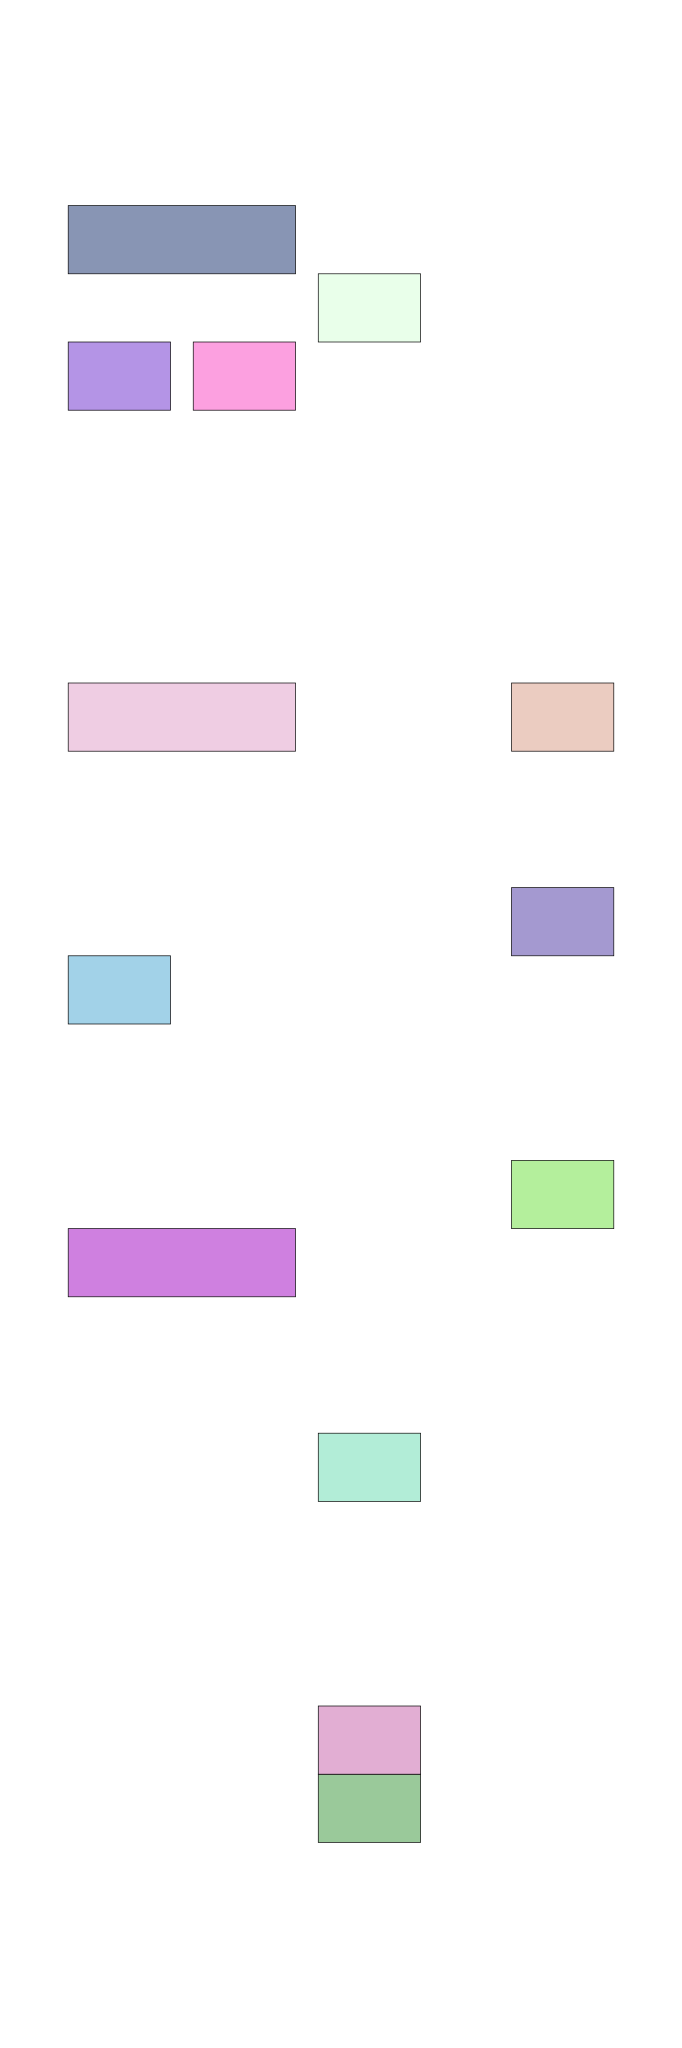

In [38]:
from IPython.display import SVG

svgPicture = '<svg width="1000" height="3000">' + svgBody + '</svg>'
SVG(svgPicture)

### V Mongo

In [118]:
userCollection = client['test_database']['users']
eventCollection = client['test_database']['events']

for index, doc in enumerate(await mongoReadDocs(userCollection)):
    events = randomEvents(teacherId=doc['_id'])
    await mongoCreateDocs(eventCollection,  *events)
    
for index, doc in enumerate(await mongoReadDocs(eventCollection)):
    print(index, doc)

0 {'_id': ObjectId('625695674015779cfa8983ba'), 'from': datetime.datetime(2022, 4, 22, 8, 0), 'to': datetime.datetime(2022, 4, 22, 9, 30), 'length': 1, 'teacherId': ObjectId('625673224015779cfa89834f')}
1 {'_id': ObjectId('625695674015779cfa8983bb'), 'from': datetime.datetime(2022, 4, 13, 8, 0), 'to': datetime.datetime(2022, 4, 13, 11, 20), 'length': 2, 'teacherId': ObjectId('625673224015779cfa89834f')}
2 {'_id': ObjectId('625695674015779cfa8983bc'), 'from': datetime.datetime(2022, 4, 10, 9, 50), 'to': datetime.datetime(2022, 4, 10, 11, 20), 'length': 1, 'teacherId': ObjectId('625673224015779cfa89834f')}
3 {'_id': ObjectId('625695674015779cfa8983bd'), 'from': datetime.datetime(2022, 4, 6, 8, 0), 'to': datetime.datetime(2022, 4, 6, 9, 30), 'length': 1, 'teacherId': ObjectId('625673224015779cfa89834f')}
4 {'_id': ObjectId('625695674015779cfa8983be'), 'from': datetime.datetime(2022, 4, 27, 8, 0), 'to': datetime.datetime(2022, 4, 27, 11, 20), 'length': 2, 'teacherId': ObjectId('62567322401

In [122]:
#emit(this.name.substr(0, 4), this.actualDebt);
mapFunction = '''function() {
    if (this.length) {
       emit(this.teacherId, this.length);
    }
};'''

reduceFunction ='''function(keyCustId, lengths) {
   return Array.sum(lengths);
};'''

eventCollection = client['test_database']['events']
reduced = await eventCollection.inline_map_reduce(mapFunction, reduceFunction)
print(reduced)

[{'_id': ObjectId('625673224015779cfa89834f'), 'value': 28.0}, {'_id': ObjectId('625682d04015779cfa898376'), 'value': 26.0}, {'_id': ObjectId('625673224015779cfa898355'), 'value': 21.0}, {'_id': ObjectId('625682ba4015779cfa898374'), 'value': 18.0}, {'_id': ObjectId('625682ba4015779cfa898372'), 'value': 16.0}, {'_id': ObjectId('625682df4015779cfa89838a'), 'value': 24.0}, {'_id': ObjectId('625681794015779cfa89835b'), 'value': 14.0}, {'_id': ObjectId('625682df4015779cfa898389'), 'value': 10.0}, {'_id': ObjectId('625682ad4015779cfa898362'), 'value': 14.0}, {'_id': ObjectId('625682ad4015779cfa898363'), 'value': 15.0}, {'_id': ObjectId('625682ba4015779cfa89836b'), 'value': 19.0}, {'_id': ObjectId('625682ad4015779cfa898369'), 'value': 13.0}, {'_id': ObjectId('625682df4015779cfa898382'), 'value': 17.0}, {'_id': ObjectId('625682ad4015779cfa898361'), 'value': 26.0}, {'_id': ObjectId('625682d04015779cfa89837d'), 'value': 16.0}, {'_id': ObjectId('625682974015779cfa89835e'), 'value': 18.0}, {'_id':

In [130]:
def createFilteredMap(query):
    return f'''function() {{
    if ({query}) {{
       emit(this.teacherId, this.length);
    }}
}};'''


reduceFunction ='''function(keyCustId, lengths) {
   return Array.sum(lengths);
};'''

userCollection = client['test_database']['users']
firstUser = (await mongoReadDocs(userCollection, limit=1))[0]

mapFunction = createFilteredMap(f'this.teacherId == "{firstUser["_id"]}"') # pozor na == vs. === (rovnost vs. identita)
print(mapFunction)

eventCollection = client['test_database']['events']
reduced = await eventCollection.inline_map_reduce(mapFunction, reduceFunction)
print(reduced)

function() {
    if (this.teacherId == "625673224015779cfa89834f") {
       emit(this.teacherId, this.length);
    }
};
[{'_id': ObjectId('625673224015779cfa89834f'), 'value': 28.0}]


## Sharding

https://hub.docker.com/r/bitnami/mongodb-sharded/